In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import string
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


### Load the data
reusing IMDB reviews

In [2]:
''' load the data '''
# the dataset is in one of the ancillary tensorflow libraries
# some more information can be found here: https://www.tensorflow.org/datasets/catalog/imdb_reviews

# the dataset class is very useful to understand and an important tool for dealing with
# larger datasets, but this is outside of what we're looking at now.

# this downloads the dataset into this session, and will be removed when this notebook is restarted
train_dataset, test_dataset = tfds.load("IMDBReviews",
                                        batch_size = 16,
                                        split = ['train','test'])



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVE0WDF/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVE0WDF/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVE0WDF/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
''' function to remove punctuation and html breaks '''
def custom_standardization(input_data): # keras text from scratch
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ") # this removes <br />
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", "") # this removes punctuations


In [4]:
# Extract all the training data strings into a simple list
# each element is a review

# initialize a list
text_ds = list()
# fill with the training dataset
for batch in tqdm(train_dataset):
    for i in batch['text']:
      text_ds.append(i.numpy())
# check the length of this dataset
len(text_ds)

100%|██████████| 1563/1563 [00:08<00:00, 191.13it/s]


25000

### Method 1

Split review into chunks of some fixed size
Use inputs to create a hidden state

Predict the final word given that hidden state

In [5]:
''' a timeseries function to divide data up into meaningful windows '''
def timeseries_split(data, step = 1, window = 20):
  '''
  splits a timeseries into samples of a given size

  data: is an array (timesteps, features)
  step: is the offset between subsequent samples
  window: is how much data to put in the sample (automatically adds the t+1 prediction)
  '''
  samples=list()
  for i in range(int((len(data)-(window+1))/step)):
    data_temp = data[(i*step):(i*step) + window + 1]
    samples.append(data_temp)
  return np.array(samples)

In [6]:
''' implement the vectorization layer '''

# layer constants
vocab_length = 20000 # <- how many different words to have in the vocabulary
embedding_dim = 64
sequence_length = 500 # <- review length (clip or pad as needed)

vectorize_layer = tf.keras.layers.TextVectorization(
        standardize = custom_standardization, # alternatively: 'lower_and_strip_punctuation'
        max_tokens = vocab_length,
        output_mode = "int",
        output_sequence_length = sequence_length )


In [7]:
''' adapt the layer to the training dataset '''
# this figures out which words to keep and which to discard
vectorize_layer.adapt(text_ds)

# converting words to integers
# (this will be rolled into the model, but we can investigate things here first)
vectorized_data = vectorize_layer(text_ds)

vectorized_data.shape

TensorShape([25000, 500])

In [8]:
'''
splits the chunks of text into lengths of 20
drop any samples that have [UNK] or padding
'''

timesplit = list()

for _sample in tqdm(vectorized_data):

    # clip to the padding (way faster)
    _sample = np.array(_sample)
    mask = (_sample == 0)
    z = timeseries_split(_sample[:mask.argmax()])

    # remove any samples predicting [UNK]
    for i in z:
      if i[-1] != 1:
        timesplit.append(i)

timesplit = np.array(timesplit)
print('n samples:',timesplit.shape[0])


100%|██████████| 25000/25000 [00:18<00:00, 1333.38it/s]


n samples: 3809573


In [9]:
# recreate the samples in word format (to reinitialize the vectorize layer). issue with padding on vectorize layer that I don't know how to adjust

rebuilt_review_chunks = list()

vocab_dict = vectorize_layer.get_vocabulary() # pulling this outside the loop sped it up by ~ 200 million times

for _sample in tqdm(timesplit):
    temp_review_chunk = list()
    for _word_idx in _sample:
      temp_review_chunk.append(vocab_dict[_word_idx])
    rebuilt_review_chunks.append(' '.join(temp_review_chunk))


100%|██████████| 3809573/3809573 [00:26<00:00, 143953.97it/s]


In [10]:

split_review = list()

for i in tqdm(rebuilt_review_chunks[:50000]): # proof of concept using a subset of 50k samples
    split_review.append(i.split(' '))
split_review = np.array(split_review)

print(split_review.shape)
print(split_review[0])


100%|██████████| 50000/50000 [00:00<00:00, 115205.66it/s]


(50000, 21)
['this' 'was' 'an' 'absolutely' 'terrible' 'movie' 'dont' 'be' 'lured'
 'in' 'by' 'christopher' 'walken' 'or' 'michael' 'ironside' 'both' 'are'
 'great' 'actors' 'but']


In [11]:
''' this feels wrong '''
# rebuilding to fix padding (there might be a better way to do this)

vectorize_layer2 = tf.keras.layers.TextVectorization(
        standardize = custom_standardization,
        max_tokens = vocab_length,
        output_mode = "int",
        output_sequence_length = 20, # <<< reduce padding to 20
        vocabulary = vectorize_layer.get_vocabulary()) # use the previous vocabulary

# do not need to readapt this layer since we're passing in a vocabulary

In [12]:
# one hot for outputs

print(split_review.shape)

print(split_review[:,-1].shape)

print(vectorize_layer2(split_review[:,-1]).shape)

print(vectorize_layer2(split_review[:,-1])[:,0].shape)

print(vectorize_layer2(split_review[:,-1])[:10,0])

targets = tf.keras.utils.to_categorical(vectorize_layer2(split_review[:,-1])[:,0])

(50000, 21)
(50000,)
(50000, 20)
(50000,)
tf.Tensor([ 18  11 219 318  26  64 241 211   8 476], shape=(10,), dtype=int64)


In [13]:
def build_text_model():
  xin = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
  x0 = vectorize_layer2(xin)
  x0 = tf.keras.layers.Embedding(vocab_length,
                                 embedding_dim,
                                 embeddings_regularizer=tf.keras.regularizers.l2(1e-4),)(x0)
  x0 = tf.keras.layers.LSTM(64)(x0)
  x0 = tf.keras.layers.Flatten()(x0)
  x0 = tf.keras.layers.Dense(64,activation='swish')(x0)
  xout = tf.keras.layers.Dense(targets.shape[1],activation='softmax')(x0)
  return tf.keras.models.Model(xin,xout)

scratch_model = build_text_model()

In [14]:
scratch_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 20)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 20, 64)            1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                             

In [15]:
scratch_model.compile(loss="categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                      metrics=["acc"])

In [16]:
# take the separated words and combine them back into sentences
# the model's "vectorizelayer" expects sentences

split_review_merged = list()
for _sample in split_review:
    split_review_merged.append(' '.join(_sample[:-1]))

In [17]:
''' train the thing '''

# prepare the target outputs

hist = scratch_model.fit(np.array(split_review_merged),
                         targets,
                         validation_split=0.05,
                         epochs=20,
                         batch_size = 16)


Epoch 1/20
2969/2969 [==============================] - 136s 43ms/step - loss: 7.2531 - acc: 0.0608 - val_loss: 7.0433 - val_acc: 0.0608
Epoch 2/20
2969/2969 [==============================] - 122s 41ms/step - loss: 6.6628 - acc: 0.0615 - val_loss: 7.1158 - val_acc: 0.0608
Epoch 3/20
2969/2969 [==============================] - 121s 41ms/step - loss: 6.5857 - acc: 0.0615 - val_loss: 7.2476 - val_acc: 0.0608
Epoch 4/20
2969/2969 [==============================] - 123s 41ms/step - loss: 6.5426 - acc: 0.0615 - val_loss: 7.3333 - val_acc: 0.0608
Epoch 5/20
2969/2969 [==============================] - 123s 41ms/step - loss: 6.5012 - acc: 0.0615 - val_loss: 7.4641 - val_acc: 0.0608
Epoch 6/20
2969/2969 [==============================] - 122s 41ms/step - loss: 6.4385 - acc: 0.0639 - val_loss: 7.5283 - val_acc: 0.0648
Epoch 7/20
2969/2969 [==============================] - 122s 41ms/step - loss: 6.3646 - acc: 0.0683 - val_loss: 7.5011 - val_acc: 0.0676
Epoch 8/20
2969/2969 [===================

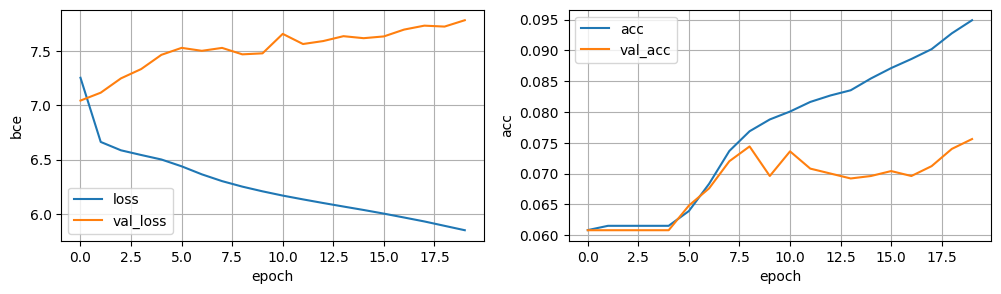

In [18]:
# look at curves

fig,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[1].plot(hist.history['acc'], label='acc')
ax[1].plot(hist.history['val_acc'], label='val_acc')
ax[0].set_ylabel('bce'); ax[1].set_ylabel('acc')
for i in range(2): ax[i].legend(); ax[i].grid(); ax[i].set_xlabel('epoch');

### method 1: model sanity check

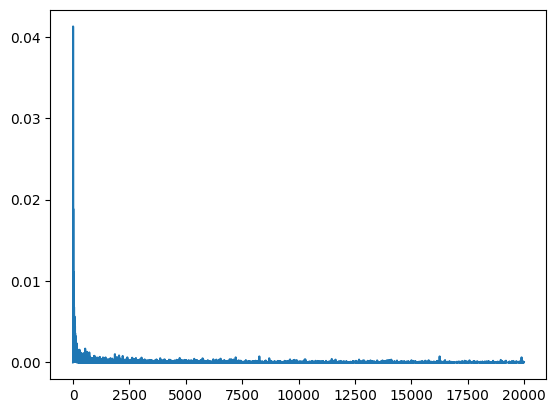

In [21]:
preds = scratch_model.predict([['i hated this crap movie. terrible, never see '],
                       ['bad'],
                       ['great film. alan rickman was amaze-balls'],
                       [''],
                       ['not good']]) # what happens if the model gets no input (what is the bias?)

# it seems like the model has a hard time with short reviews, and maybe has a negative bias
# how can we check this correlation?
plt.plot(preds[0]).shape

In [22]:
print(np.array(vectorize_layer2.get_vocabulary())[tf.argmax(preds,axis=1)])

tf.reduce_max(preds,axis=1)


['and' 'the' 'the' 'the' 'the']


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.04125864, 0.09238204, 0.09123676, 0.08022653, 0.08955672],
      dtype=float32)>

In [23]:
# when in doubt, take the most common word
vectorize_layer2.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'a']

## Method 2
Save Hidden states<br>
from: https://www.tensorflow.org/text/tutorials/text_generation

In [24]:
# visualize an example of offsetting this
front_bias = text_ds[0].decode().split(' ')[:-1]
end_bias   = text_ds[0].decode().split(' ')[1:]

print(front_bias[:10])
print('       ',end_bias[:10])

['This', 'was', 'an', 'absolutely', 'terrible', 'movie.', "Don't", 'be', 'lured', 'in']
        ['was', 'an', 'absolutely', 'terrible', 'movie.', "Don't", 'be', 'lured', 'in', 'by']


In [25]:
''' implement the vectorization layer '''

# layer constants
vocab_length = 20000 # <- how many different words to have in the vocabulary
embedding_dim = 64
sequence_length = 100 # <- review length (clip or pad as needed)

vectorize_layer = tf.keras.layers.TextVectorization(
        standardize = custom_standardization, # alternatively: 'lower_and_strip_punctuation'
        max_tokens = vocab_length,
        output_mode = "int",
        output_sequence_length = sequence_length )


In [26]:
''' adapt the layer to the training dataset '''
# this figures out which words to keep and which to discard
vectorize_layer.adapt(text_ds)

# converting words to integers
# (this will be rolled into the model, but we can investigate things here first)
vectorized_data = vectorize_layer(text_ds)

vectorized_data.shape

TensorShape([25000, 100])

In [27]:
# sample init

front_bias_data = list()
end_bias_data = list()

for _vectorized_review in tqdm(vectorized_data):
  # split review
  front_bias_data.append(_vectorized_review[:-1])
  end_bias_data.append(_vectorized_review[1:])



100%|██████████| 25000/25000 [00:24<00:00, 1031.29it/s]


In [34]:
front_bias_data[0]

<tf.Tensor: shape=(99,), dtype=int64, numpy=
array([   11,    13,    33,   414,   380,    17,    89,    26, 10552,
           8,    32,  1336,  3544,    41,   489, 11365,   190,    23,
          84,   151,    18,    11,   219,   318,    26,    64,   241,
         211,     8,   476,    53,    64,    84,   111,    97,    21,
        5574,    11,    92,   633,   729,    11,    17,     7,    33,
         396,  9232,   167,  2462,   408,     2,    88,  1192,   135,
          65,   143,    51,     2,     1,  7488,    65,   247,    64,
        2835,    15, 17840,  2869,     1, 19460,  1436,  4862,     3,
          39,     1,  1546,    16,  3544,    13,   156,    18,     4,
        1192,   894,  7960,     8,     4,    17,    12,    13,  4064,
           5,    99,   146,  1229,    10,   236,   663,    12,    47])>

In [28]:
class MyModel(tf.keras.Model):
  '''
  from tensorflow text_generation
  https://www.tensorflow.org/text/tutorials/text_generation
  '''
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [29]:
my_better_model = MyModel(vocab_size=vocab_length,
                embedding_dim=embedding_dim,
                rnn_units=64)


In [30]:
# check this model works
my_better_model(tf.reshape(front_bias_data[0],(1,-1))) # reshape needed to create batch_size dimension


<tf.Tensor: shape=(1, 99, 20000), dtype=float32, numpy=
array([[[-6.62954233e-04, -2.46951007e-04, -3.12671065e-04, ...,
          5.57333289e-04, -5.71313023e-04, -9.37715347e-04],
        [-9.25280037e-04, -6.37118123e-04,  9.48757661e-05, ...,
          1.51590595e-03,  4.67175596e-05, -5.81391098e-04],
        [-3.10029369e-04,  4.87508078e-04,  1.04920364e-04, ...,
         -2.95051927e-04,  1.12095928e-04, -2.06093537e-03],
        ...,
        [ 9.65114887e-05,  2.03805786e-04,  1.53236161e-03, ...,
         -8.60978791e-04, -2.51833786e-04, -8.80697917e-05],
        [-5.55419130e-04,  5.05262753e-04,  1.06882001e-03, ...,
         -7.67224934e-04, -1.03060179e-03, -9.60488396e-04],
        [-1.04111386e-03,  4.09084809e-04,  1.06521870e-03, ...,
          5.24001953e-04,  1.01574791e-04,  5.77769824e-04]]],
      dtype=float32)>

In [31]:
''' put these into a tf.Dataset format '''
# probably avoidable, but other ways were causing issues. This follows the tf guide more closely

nwp_ds = tf.data.Dataset.from_tensor_slices((np.array(front_bias_data),
                                              np.array(end_bias_data)))

nwp_ds = nwp_ds.batch(64, drop_remainder=True)

for input_example_batch, target_example_batch in nwp_ds.take(1):
    print(input_example_batch.shape)
    print(target_example_batch.shape)
    example_batch_predictions = my_better_model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")



(64, 99)
(64, 99)
(64, 99, 20000) # (batch_size, sequence_length, vocab_size)


In [32]:
''' prepare the model '''
# sparse cat cross entropy does some 'under the hood' processing for us.
# "from_logits" means we did not apply the softmax, and indicates this objective
# function should do that before calculating the error
# (logits show up frequently in ML)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

my_better_model.compile(optimizer = 'adam',
                        loss = loss,
                        metrics = ['acc'])

# and fit
hist = my_better_model.fit(nwp_ds,
                           epochs=20)

Epoch 1/20
390/390 [==============================] - 53s 130ms/step - loss: 6.9412 - acc: 0.0515
Epoch 2/20
390/390 [==============================] - 31s 80ms/step - loss: 6.6213 - acc: 0.0551
Epoch 3/20
390/390 [==============================] - 31s 80ms/step - loss: 6.4837 - acc: 0.0722
Epoch 4/20
390/390 [==============================] - 32s 81ms/step - loss: 6.0963 - acc: 0.1284
Epoch 5/20
390/390 [==============================] - 31s 81ms/step - loss: 5.7949 - acc: 0.1561
Epoch 6/20
390/390 [==============================] - 31s 81ms/step - loss: 5.6362 - acc: 0.1651
Epoch 7/20
390/390 [==============================] - 32s 81ms/step - loss: 5.5214 - acc: 0.1746
Epoch 8/20
390/390 [==============================] - 31s 80ms/step - loss: 5.4289 - acc: 0.1812
Epoch 9/20
390/390 [==============================] - 32s 81ms/step - loss: 5.3563 - acc: 0.1854
Epoch 10/20
390/390 [==============================] - 31s 81ms/step - loss: 5.2970 - acc: 0.1888
Epoch 11/20
390/390 [=======

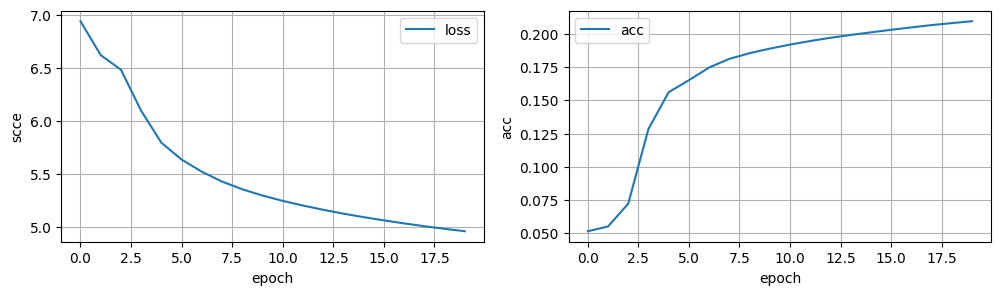

In [35]:
# look at curves

fig,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].plot(hist.history['loss'], label='loss')
#ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[1].plot(hist.history['acc'], label='acc')
#ax[1].plot(hist.history['val_acc'], label='val_acc')
ax[0].set_ylabel('scce'); ax[1].set_ylabel('acc')
for i in range(2): ax[i].legend(); ax[i].grid(); ax[i].set_xlabel('epoch');


In [41]:
''' example of post processing '''

sanity_check_text = 'this was a good film except for john'

# because our model doesn't have the vectorize_layer inside it we need to
# vectorize the input as preprocessing
# then remove any padding

# this implementation assumes the input text is shorter than the resulting padded input
words_in_input = len(sanity_check_text.split(' '))
vectorized_input_data = vectorize_layer([[sanity_check_text]])
print('vectorized input:', vectorized_input_data[:,:words_in_input])


# indicate the model should use the default hidden state
states = None

# returns states to allow continuous prediction. we will just look for next word
predicted_logits, states = my_better_model(inputs=vectorized_input_data[:,:words_in_input],
                                           states=states,
                                           return_state=True)
# Presumably the dynamic number of input tokens is handled by the recurrent layer ?

print('predicted_logits shape:', predicted_logits.shape)

# look only at the last predicted word
predicted_logits = predicted_logits[:, -1, :]
print('last word predicted_logits shape:', predicted_logits.shape)

# Sample the outputs
# randomly sample using the logit as probability (note: it expects logits)
predicted_ids = tf.random.categorical(predicted_logits, num_samples=5)
predicted_ids = tf.squeeze(predicted_ids, axis=0)

# Convert from token back to word
predicted_samples = np.array(vectorize_layer.get_vocabulary())[predicted_ids]
print('predicted_samples:', predicted_samples)

vectorized input: tf.Tensor([[ 11  13   4  49  19 547  15 302]], shape=(1, 8), dtype=int64)
predicted_logits shape: (1, 8, 20000)
last word predicted_logits shape: (1, 20000)
predicted_samples: ['waters' 'preminger' 'k' 'gainsbourg' 'sugiyama']


In [39]:
vectorize_layer.get_vocabulary().index('obrien')

8092

In [ ]:
# saving of a custom model like this is easy, but the loading is difficult.
# it needs to know how to unpack each thing (see error message in next cell)
my_better_model.save('drive/MyDrive/better_nwp.keras')

In [ ]:
# attempt to load this custom class
new_model = tf.keras.models.load_model('drive/MyDrive/better_nwp.keras')

# consider saving weights instead of trying to save the full model
# the difference is that you define an instance of a new class then insert the weights
# as opposed to model.load(), which should be able to unpack the architecture too.

TypeError: ignored